### import libary

In [30]:
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, models
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import cal_def

### make data for train , test

In [31]:
scale = MinMaxScaler(feature_range=(0, 1))

def sklearn_scaled(data, feature):
    # scale = MinMaxScaler(feature_range=(0, 1))
    for i in feature:
        data[i] = scale.fit_transform(data[i].values.reshape(-1, 1))
    return data

def split_data(data, data_range, train_ratio=0.8):
    split_range = int(len(data) * train_ratio)

    # features = [
    #     "RSI", "SMA_30", "SMA_120", "BB_upper", "SMA_210"
    #     "BB_middle", "BB_lower", "ADOSC", "close_price"
    # ]
    # features = [
    #     'SMA_30', 'SMA_120', 'SMA_210', 'RSI', 'MACD', 'MACD_Signal',
    #     'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility', 'Stochastic',
    #     "ADOSC", "OBV", "AD"
    # ]
    features = [
        'SMA_30', 'SMA_120', 'BB_upper', 'BB_middle', 'BB_lower',
        "AD", 'Volatility', "close_price", "high_price", "low_price",
        "open_price",
    ]
    data = sklearn_scaled(data, features)
    tmp = data["Target"].tolist()
    data = sklearn_scaled(data, ["Target"])
    pre_close = data["Close"]["GC=F"].to_numpy()
    pre_close = (pre_close - min(tmp)) / (max(tmp) - min(tmp))

    pre_x_train = data.iloc[:split_range].loc[:,features]
    pre_y_train = data.iloc[:split_range].loc[:,["Target"]]
    pre_x_test = data.iloc[split_range:].loc[:,features]
    pre_y_test = data.iloc[split_range:].loc[:,["Target"]]
    pre_date = data.iloc[split_range:].index.to_list()
    pre_close = pre_close[split_range:]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    date = []
    close = []
    for i in range(len(pre_x_train)-data_range):
        # x_tmp = np.transpose(pre_x_train.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_train.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_train.iloc[i+data_range-1].to_numpy()
        x_train.append(x_tmp)
        y_train.append(y_tmp)

    for i in range(len(pre_x_test)-data_range):
        # x_tmp = np.transpose(pre_x_test.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_test.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_test.iloc[i+data_range-1].to_numpy()
        x_test.append(x_tmp)
        y_test.append(y_tmp)
        date.append(pre_date[i+data_range-1])
        close.append(pre_close[i+data_range-1])
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1)
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape(-1)
    # close = np.array(close)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date), len(close))
    return x_train, y_train, x_test, y_test, date, close

def prepar_data(asset, start, end, target_date):
    data = yf.download(asset, start=start, end=end)
    data.dropna(inplace=True)

    # momentum indicator
    data['RSI'] = ta.RSI(data['Close'][asset[0]], timeperiod=14)
    data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'][asset[0]], fastperiod=12, slowperiod=26, signalperiod=9)
    data['Momentum'] = ta.MOM(data['Close'][asset[0]], timeperiod=10)
    data['Stochastic'] = ta.STOCH(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], fastk_period=14, slowk_period=3)[0]

    # volatility indicator
    data['Volatility'] = ta.ATR(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], timeperiod=14)
    data["NATR"] = ta.NATR(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], timeperiod=14)

    # overlap studies functions
    data['SMA_30'] = ta.MA(data['Close'][asset[0]], timeperiod=30)
    data['SMA_120'] = ta.MA(data['Close'][asset[0]], timeperiod=100)
    data['SMA_210'] = ta.MA(data['Close'][asset[0]], timeperiod=200)
    data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'][asset[0]], timeperiod=20)
    
    # volume indicator
    data["AD"] = ta.AD(data["High"][asset[1]], data["Low"][asset[1]], data["Close"][asset[1]], data["Volume"][asset[1]])
    data["ADOSC"] = ta.ADOSC(data["High"][asset[1]], data["Low"][asset[1]], data["Close"][asset[1]], data["Volume"][asset[1]], fastperiod=3, slowperiod=10)
    data["OBV"] = ta.OBV(data["Close"][asset[1]], data["Volume"][asset[1]])
    data["close_price"] = data["Close"][asset[0]]
    data["high_price"] = data["High"][asset[0]]
    data["low_price"] = data["Low"][asset[0]]
    data["open_price"] = data["Open"][asset[0]]

    # target of predict
    data["Target"] = data["Close"][asset[0]].shift(-target_date)

    data.dropna(inplace=True)
    return data

def model_lstm(range_input=30, neurons=16, n_feature=3):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(range_input, n_feature)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
    return model

[*********************100%***********************]  2 of 2 completed


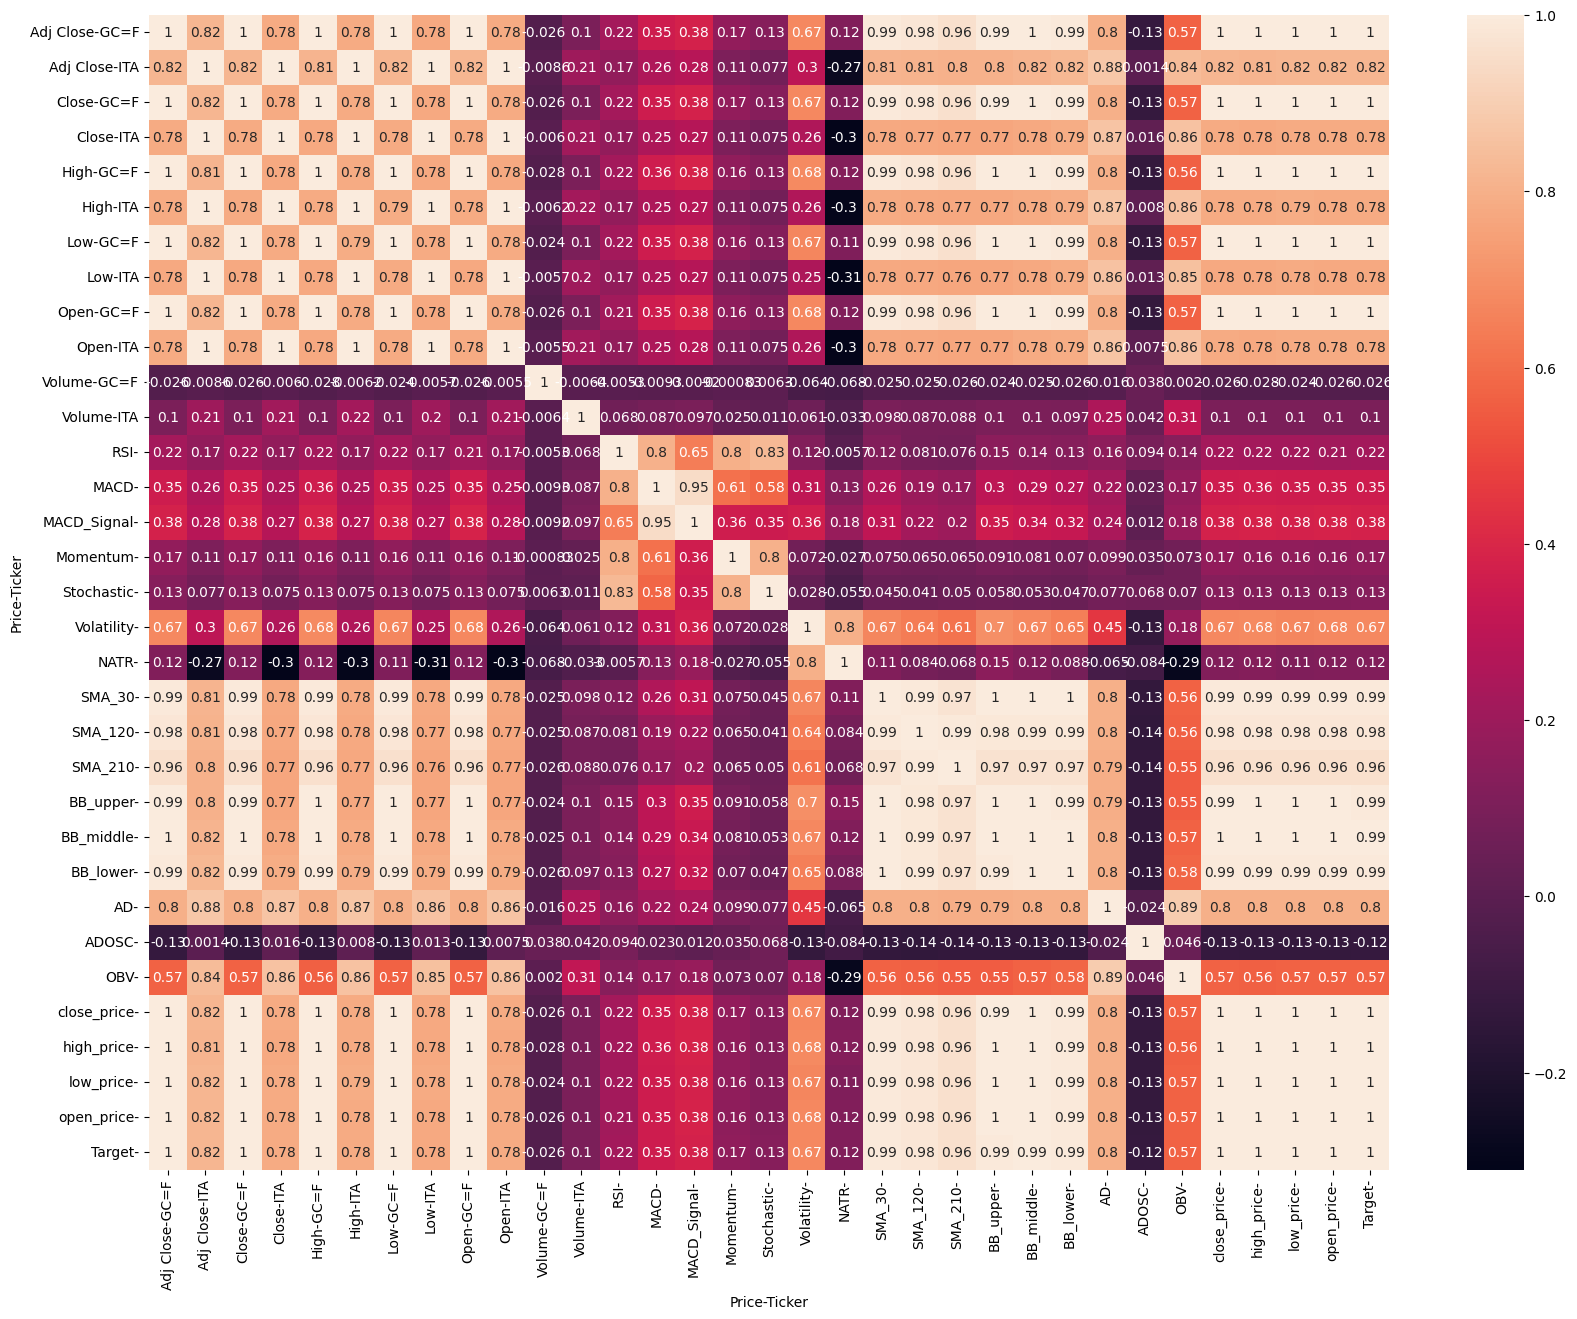

In [20]:
import seaborn as sb
data = prepar_data(["GC=F", "ITA"], '2014-01-01', '2024-12-01', 1)
# features = [
#         "SMA_30", "SMA_120", "BB_upper",
#         "BB_middle", "BB_lower", "AD", "ADOSC", "OBV",
#     ]
plt.figure(figsize=(20, 15))
sb.heatmap(data.corr(), annot=True)
plt.show()
# x_train, y_train, x_test, y_test, date, close = split_data(data.copy(), data_range=30, train_ratio=0.5)
# # i = features[4]
# # for i in features:
# #     plt.plot(data[i], label = i)
# plt.plot(data["ADOSC"], label = "ADOSC")
# plt.plot(data["MACD_Signal"], label = "MACD_Signal")
# plt.legend()
# plt.show()

In [94]:
pct = data.loc[date]["Close"]["GC=F"].pct_change().cumsum()

# -----------------------------------------------------------------------------------

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228
Epoch 1/60


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0115
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0026
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0014
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0010  
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0010
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 9.5881e-04
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 9.0250e-04
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8.3181e-04
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8.0390e-04
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.5644e-04
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.6597e-04
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.5330e-04
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.2134e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 7.1255e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.3816e-04
Epo

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228
Epoch 1/60


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0088
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0021
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0015
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0010
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 8.8671e-04
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 8.3007e-04 
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 7.7939e-04
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 7.8481e-04
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 7.6067e-04
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 7.3511e-04
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 7.3397e-04
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 7.3505e-04
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 7.3410e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 7.1438e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 7

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228
Epoch 1/60


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0146
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0036
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0019
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0012
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0011
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0012
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0010
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.8709e-04
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 9.9956e-04
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0010
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.6909e-04
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.8019e-04
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.4953e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.3893e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.7371e-04
Epoch 16/60
7/7 ━

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228
Epoch 1/60


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0132
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0028
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0015
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0010
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.2147e-04
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 8.3805e-04
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.6212e-04
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 7.9297e-04
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.8838e-04
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.9506e-04
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.7659e-04
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.6492e-04
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.9462e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 7.6554e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.6489e-04
E

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228
Epoch 1/60


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0197
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0024
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0012 
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0010 
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0010 
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 8.5734e-04 
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 8.3749e-04
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.4526e-04 
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.7685e-04 
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 7.2892e-04
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.2569e-04
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 6.8458e-04
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.0682e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 6.6470e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 6.5655e-04

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228
Epoch 1/60


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0126
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0019
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0012
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 9.7026e-04
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 8.3578e-04
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 8.6199e-04
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 8.2858e-04
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 8.2365e-04
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.7705e-04
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 7.2748e-04
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 7.3463e-04
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 7.2449e-04
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 7.3837e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.1776e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 7.3915e

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0078
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0026
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0014
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0011  
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 9.2565e-04
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 8.9350e-04
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 9.0537e-04
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 8.2793e-04
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 7.9557e-04
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 7.8043e-04
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 7.4044e-04
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 7.4930e-04
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 7.3621e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 7.1499e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165

[*********************100%***********************]  2 of 2 completed


(1227, 30, 11) (1227,) (1228, 30, 11) (1228,) 1228 1228
Epoch 1/60


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0107
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0025
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0013
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0011
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0010 
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.8462e-04
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 9.9587e-04
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 9.3015e-04 
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 8.9114e-04 
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 9.4415e-04
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 9.1894e-04 
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 8.7689e-04 
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 8.9457e-04
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 9.0141e-04
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 9.1086e-04


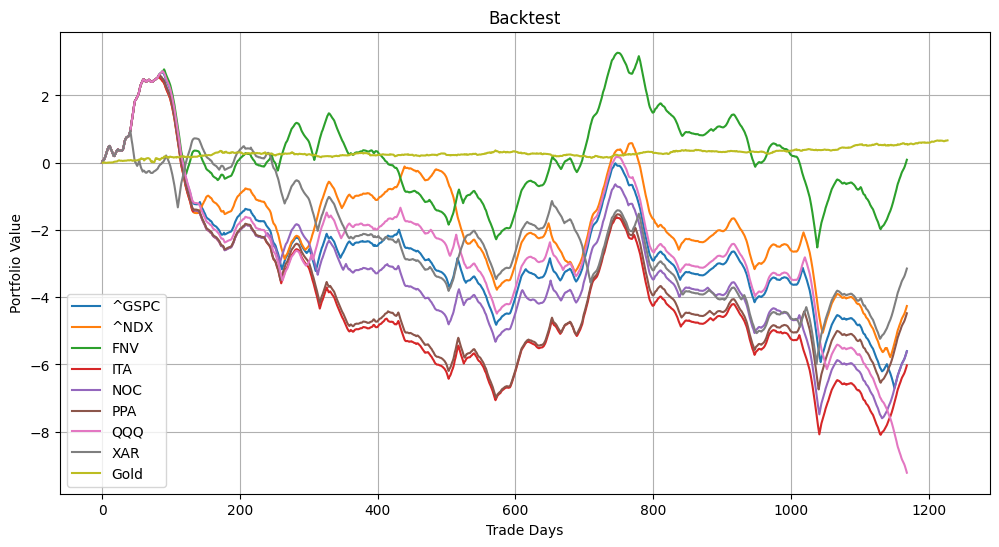

In [41]:
plt.figure(figsize=(12, 6))
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.grid(True)

finances = []

vol = ["^GSPC", "^NDX", "FNV", "ITA", "NOC", "PPA", "QQQ", "XAR"]
# vol = ["^GSPC"]
for v in vol:
    finance = []
    asset = ["GC=F", v]
    taget_date = 30
    data = prepar_data(asset, '2014-01-01', '2024-12-01', taget_date)
    x_train, y_train, x_test, y_test, date, close = split_data(data.copy(), data_range=30, train_ratio=0.5)

    model = model_lstm(range_input=x_train.shape[1], n_feature=x_train.shape[2], neurons=200)
    history = model.fit(x_train, y_train, batch_size=200, epochs=60)
    scale_predict = model.predict(x_test)

    capital = 10
    capital_history = [capital]
    open_status = False

    count_day = 0

    for i in range(taget_date, len(scale_predict) - taget_date):
        today_price = data["Close"]["GC=F"].loc[date[i]]
        future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
        # day_change = (scale_predict[i] - close[i])
        day_change = (scale_predict[i] - scale_predict[i-taget_date])
        # if open_status:
        #     count_day += 1
        #     if count_day == taget_date:
        #         open_status = False
        if abs(day_change) > 0.0:
            open_status = True
            count_day = 0
            capital *= 0.999
            if day_change > 0:
                profit = (future_price - today_price) / today_price * capital
            else:
                profit = (today_price - future_price) / today_price * capital
            # profit_list.append(profit+profit_list[-1])
            capital += profit
            capital *= 0.999
        
        capital_history.append(capital)
    finance = [v, cal_def.cal_cagr(capital_history), cal_def.cal_max_drawdown(capital_history)[0], cal_def.cal_sd(capital_history)*np.sqrt(20)]
    finances.append(finance)
    profit = [0]
    for i in range(len(capital_history) - 1):
        profit.append((capital_history[i+1]-capital_history[i])/capital_history[i] + profit[-1])
    plt.plot(profit, label=v)
pct = data.loc[date]["Close"]["GC=F"].pct_change().cumsum().to_list()
plt.plot(pct, label="Gold")
plt.legend()
plt.show()

In [39]:
df = pd.DataFrame(finances, columns=["asset", "CAGR", "Max Drawdown", "SD"])
print(df)

   asset      CAGR  Max Drawdown         SD
0  ^GSPC -0.399076      0.929281   9.592107
1   ^NDX -0.330711      0.899119  12.106199
2    FNV -0.290211      0.928088  18.564081
3    ITA -0.329146      0.914969  14.074107
4    NOC -0.363798      0.923629  12.272703
5    PPA -0.257428      0.882078  13.682620
6    QQQ -0.376771      0.923866  11.200371
7    XAR -0.233047      0.906465  19.233998


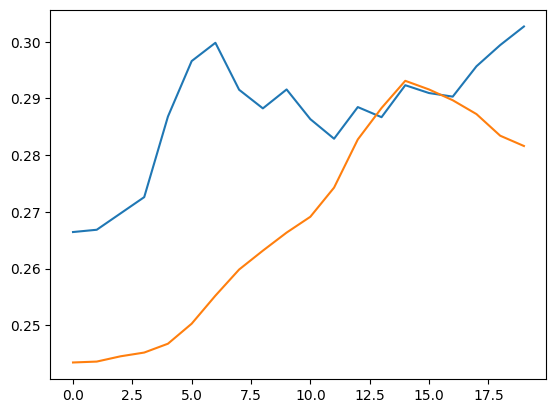

In [36]:
plt.plot(y_test[:20])
plt.plot(scale_predict[:20])

In [22]:
asset = ["GC=F", "^GSPC"]
taget_date = 7
data = prepar_data(asset, '2014-01-01', '2024-12-01', taget_date)
# data = prepar_data(["GC=F"], '2014-01-01', '2024-12-01')
data.shape

[*********************100%***********************]  2 of 2 completed


(2648, 29)

In [23]:
x_train, y_train, x_test, y_test, date, close = split_data(data.copy(), data_range=30, train_ratio=0.5)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date))

(1294, 30, 15) (1294,) (1294, 30, 15) (1294,) 1294 1294
(1294, 30, 15) (1294,) (1294, 30, 15) (1294,) 1294


### train model

ทดเผื่อเปลี่ยน activation

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0113
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.0471e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.2934e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.7861e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.0997e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.7198e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.0152e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.6390e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.6008e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.7132e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.4530e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.4682e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.5220e-04
Epoch 15/50
13/13 ━━━━━

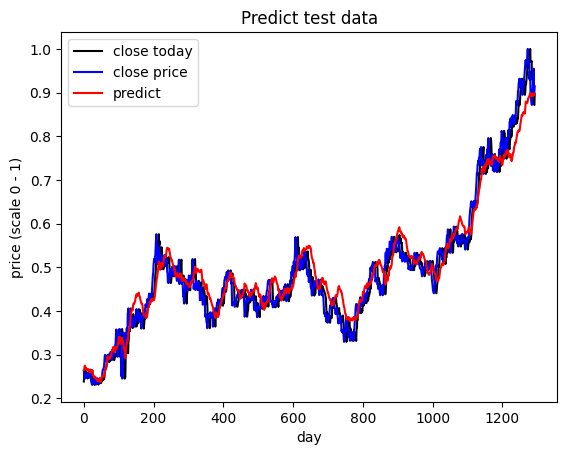

In [26]:
def model_lstm(range_input=30, neurons=16, n_feature=3):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(range_input, n_feature)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
    return model

model = model_lstm(range_input=x_train.shape[1], n_feature=x_train.shape[2], neurons=200)
history = model.fit(x_train, y_train, batch_size=100, epochs=50)

# plt.plot(history.history["loss"])
scale_predict = model.predict(x_test)
plt.plot(close, c="k", label="close today")
plt.plot(y_test, c="b", label="close price")
plt.plot(scale_predict, c="r", label="predict")
plt.title("Predict test data")
plt.xlabel("day")
plt.ylabel("price (scale 0 - 1)")
plt.legend()

mse = np.mean((y_test-scale_predict.flatten())**2)
rmse = np.sqrt(mse)
mae = np.mean(abs(y_test-scale_predict.flatten()))
print(mse)
print(rmse)
print(mae)

In [ ]:
# model = models.load_model("model/lstm_36n_.h5")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


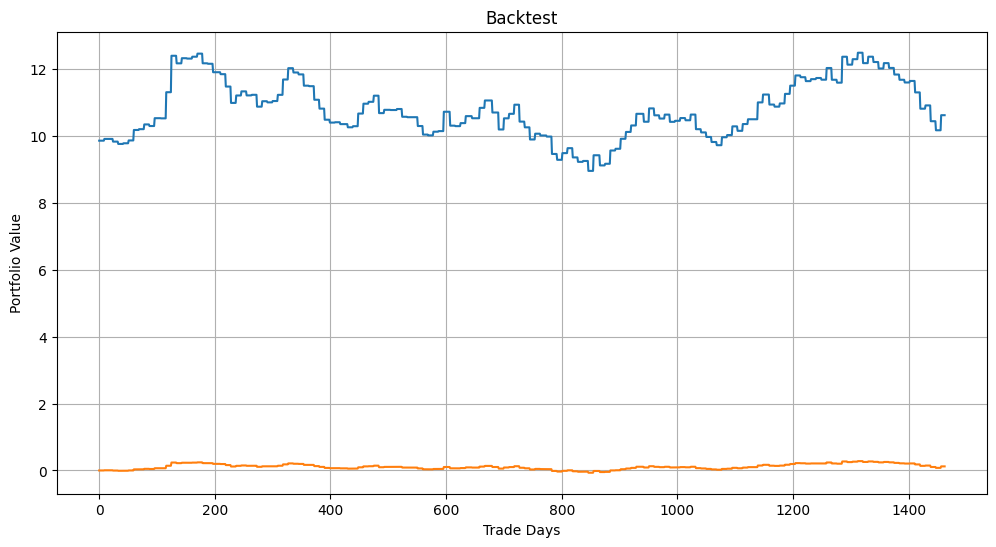

In [30]:
scale_predict = model.predict(x_test)
capital = 10
capital_history = []
open_status = False

count_day = 0

for i in range(taget_date, len(scale_predict) - taget_date):
    today_price = data["Close"]["GC=F"].loc[date[i]]
    future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
    # t = data["Target"].loc[date[i]]
    day_change = (scale_predict[i] - close[i])
    # day_change = (scale_predict[i] - scale_predict[i-taget_date])

    # print(future_price, t, day_change, today_price, scale_predict[i], scale_predict[i-taget_date])
    if open_status:
        count_day += 1
        if count_day == taget_date:
            open_status = False
        capital_history.append(capital)
        continue
    if abs(day_change) > 0.004:
        open_status = True
        count_day = 0
        capital *= 0.999
        if day_change > 0:
            profit = (future_price - today_price) / today_price * capital
        else:
            profit = (today_price - future_price) / today_price * capital
        # profit_list.append(profit+profit_list[-1])
        capital += profit
        capital *= 0.999
        capital_history.append(capital)
    else:
        capital_history.append(capital)

    capital_history.append(capital)
    # print(day_change, today_price, future_price, scale_predict[i], close[i])
    # break

profit = [0]
for i in range(len(capital_history) - 1):
    profit.append((capital_history[i+1] - capital_history[i]) / capital_history[i] + profit[-1])

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(capital_history)
plt.plot(profit)
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
# plt.legend()
plt.grid(True)
plt.show()

In [63]:
len(y_test)

1312

In [64]:
len(scale_predict)

1312

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


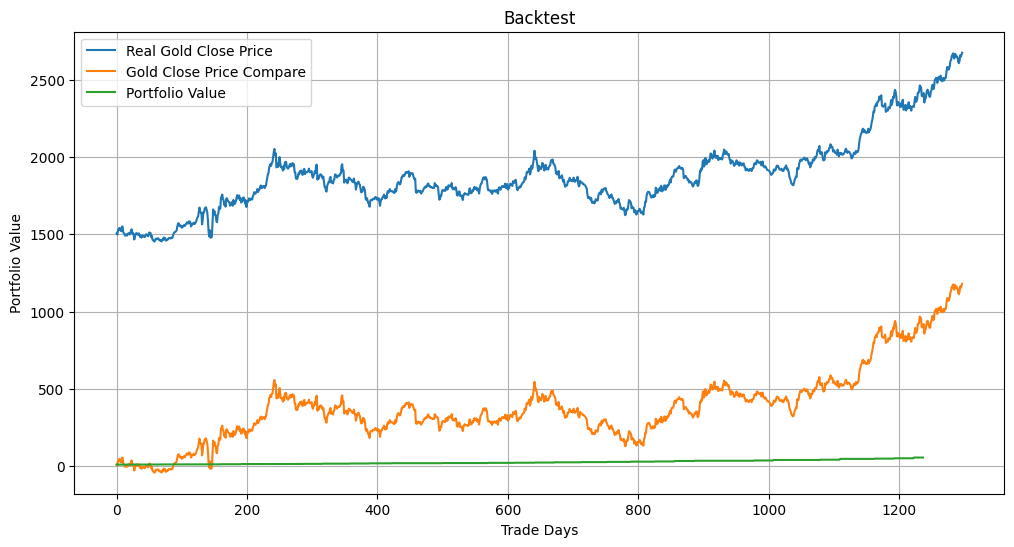

In [ ]:
scale_predict = model.predict(x_test)
capital = 10  # Initial capital
capital_history = []

open_status = False

count_day = 0

for i in range(taget_date, len(y_test) - taget_date):
    today_price = data["Close"]["GC=F"].loc[date[i]]
    future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
    t = data["Target"].loc[date[i]]
    day_change = (y_test[i]-y_test[i - taget_date])
    # print(future_price, t, day_change, today_price, scale_predict[i], scale_predict[i-taget_date])
    # if open_status:
    #     count_day += 1
    #     if count_day == taget_date-1:
    #         open_status = False
    #     capital_history.append(capital)
    #     continue
    if abs(day_change) > 0.05:
        open_status = True
        count_day = 0
        capital *= 0.999
        if day_change > 0:
            profit = (future_price - today_price) / today_price * capital
        else:
            profit = (today_price - future_price) / today_price * capital
        capital += profit
        capital *= 0.999

    capital_history.append(capital)
    
gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot((gold_close_price - (gold_close_price[0]-capital_history[0])), label="Gold Close Price Compare")
plt.plot(capital_history, label='Portfolio Value')
# plt.plot(scale_predict[:12], label="pre")
# plt.plot(y_test[:12], label="true")
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [854]:
# model = models.load_model("model/simple_lstm_model.h5")

plot graph true close price and predict close price

In [858]:
# model.save(f"model/lstm_36n_v{asset[1]}.h5")

### back test

In [114]:
scale_predict = model.predict(x_test)
capital = 10  # Initial capital
capital_history = []

csv_capital = {
    "date":[],
    "price_today":[],
    "price_next_day":[],
    "scale_day_change":[],
    "capital_befor":[],
    "capital_after":[],
    "profit":[],
    "action":[]
    }

for i in range(len(scale_predict) - 1):
    price_today = data["Close"]["GC=F"].loc[date[i]]
    price_next_day = data["Close"]["GC=F"].loc[date[i+1]]

    day_change = (scale_predict[i+1]-scale_predict[i])[0]
    
    csv_capital["date"].append(date[i])
    csv_capital["price_today"].append(price_today)
    csv_capital["price_next_day"].append(price_next_day)
    csv_capital["scale_day_change"].append(day_change)
    csv_capital["capital_befor"].append(capital)

    if abs(day_change) > 0.002:
        capital *= 0.999
        if day_change > 0:
            csv_capital["action"].append("Long")
            profit = (price_next_day - price_today) / price_today * capital
        else:
            csv_capital["action"].append("Short")
            profit = (price_today - price_next_day) / price_today * capital
        csv_capital["profit"].append(profit)
        capital += profit
        capital *= 0.999
    else:
        csv_capital["profit"].append(0)
        csv_capital["action"].append("None")
    
    csv_capital["capital_after"].append(capital)
    
    capital_history.append(capital)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


save result csv

In [860]:
csv_capital = pd.DataFrame(csv_capital)
csv_capital.to_csv("csv_file/lstm_back_test.csv", index=False)

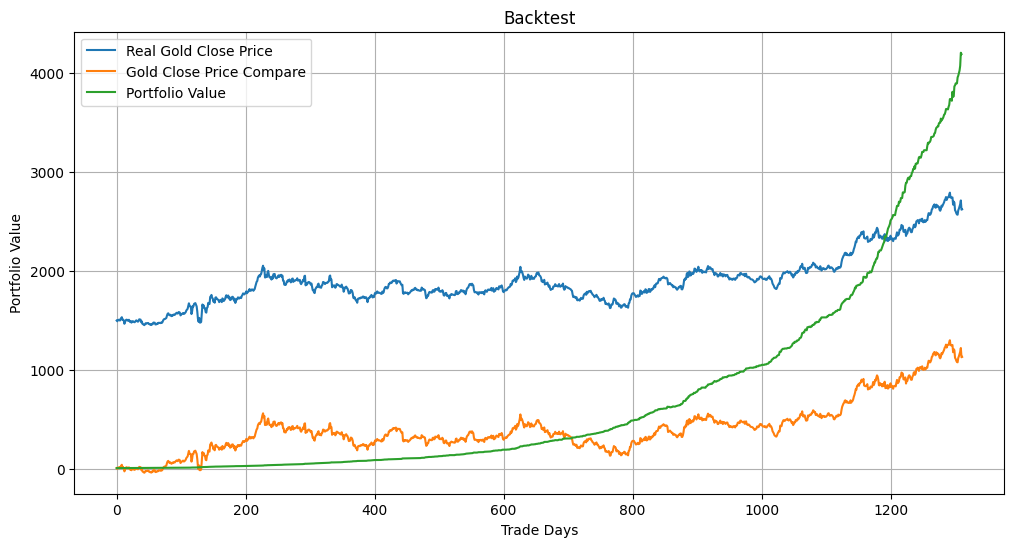

In [115]:
gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot(gold_close_price - (gold_close_price[0]-capital_history[0]), label="Gold Close Price Compare")
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

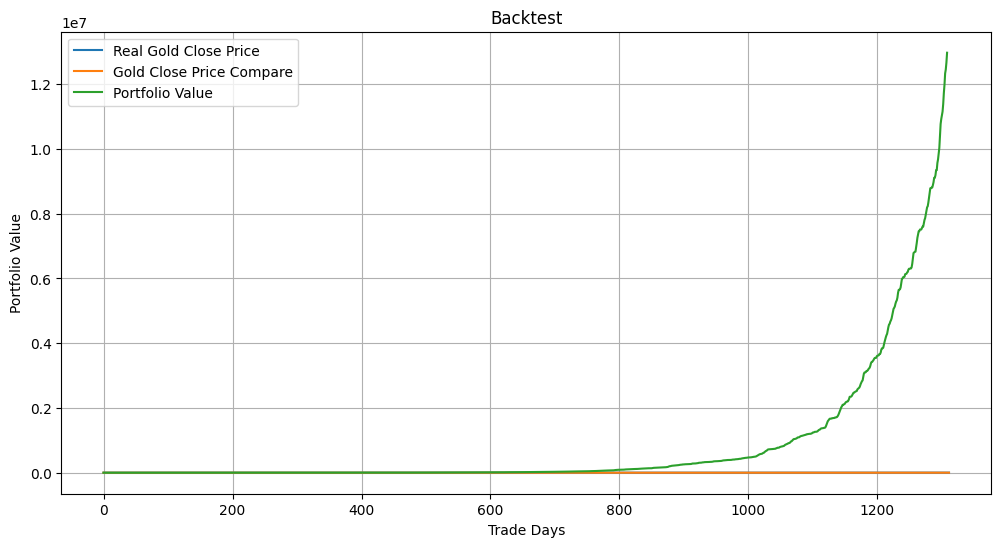

In [21]:
gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

capital = 10
capital_history = []

for i in range(len(gold_close_price) - 3):
    # print(i)
    price_today = gold_close_price[i]
    price_next_day = gold_close_price[i+3]

    dif = price_next_day - price_today
    dif = dif / price_today

    if abs(dif) > 0.002:
        # i += 7
        capital *= 0.999
        if dif > 0:
            profit = (price_next_day - price_today) / price_today * capital
        else:
            profit = (price_today - price_next_day) / price_today * capital
        capital += profit
        capital *= 0.999
    capital_history.append(capital)

# gold_close_price = data["Close"]
# gold_close_price = gold_close_price["GC=F"]
# gold_close_price = gold_close_price.loc[date].to_numpy()

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot((gold_close_price - (gold_close_price[0]-capital_history[0])), label="Gold Close Price Compare")
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

### calculate CAGR , Max Drawdown , SD

In [28]:
import cal_def
import math

cagr = cal_def.cal_cagr(capital_history)
max_dd = cal_def.cal_max_drawdown(capital_history)
sd = cal_def.cal_sd(capital_history) * math.sqrt(250)

print(f"CAGR : {cagr:.3f}")
print(f"Max Drawdown : {max_dd[0]:.3f}")
print(f"\tStart day : {max_dd[1]}\n\tEnd day : {max_dd[2]}")
print(f"SD : {sd:.3f}")

CAGR : 0.013
Max Drawdown : 0.281
	Start day : 177
	End day : 853
SD : 13.868


### evaluate

In [864]:
# model = models.load_model("model/simple_lstm_model_with_volume^GSPC.h5")

scale_predict = model.predict(x_test)

mse = np.mean((y_test-scale_predict.flatten())**2)
rmse = np.sqrt(mse)
mae = np.mean(abs(y_test-scale_predict.flatten()))
print(mse)
print(rmse)
print(mae)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.0025594482566029387
0.050590989875697615
0.03156740397490249


In [865]:
tmp = data.loc[date, "Close"]
tmp = tmp["GC=F"].pct_change().to_list()[1:]

- 0 none
- 1 buy
- 2 sell

In [866]:
con_matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

for i in range(len(tmp)):
    action = csv_capital["action"][i]
    if action == "None":
        col = 0
    elif action == "Long":
        col = 1
    else:
        col = 2
    
    real = tmp[i]
    if abs(real) <= 0.002:
        row = 0
    elif real > 0:
        row = 1
    else:
        row = 2
    con_matrix[row][col] += 1
for i in con_matrix:
    print(i)

[133, 88, 60]
[187, 331, 57]
[183, 46, 226]


### all model

In [3]:
import cal_def
import math

cagr = []
max_dd = []
sd = []

[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


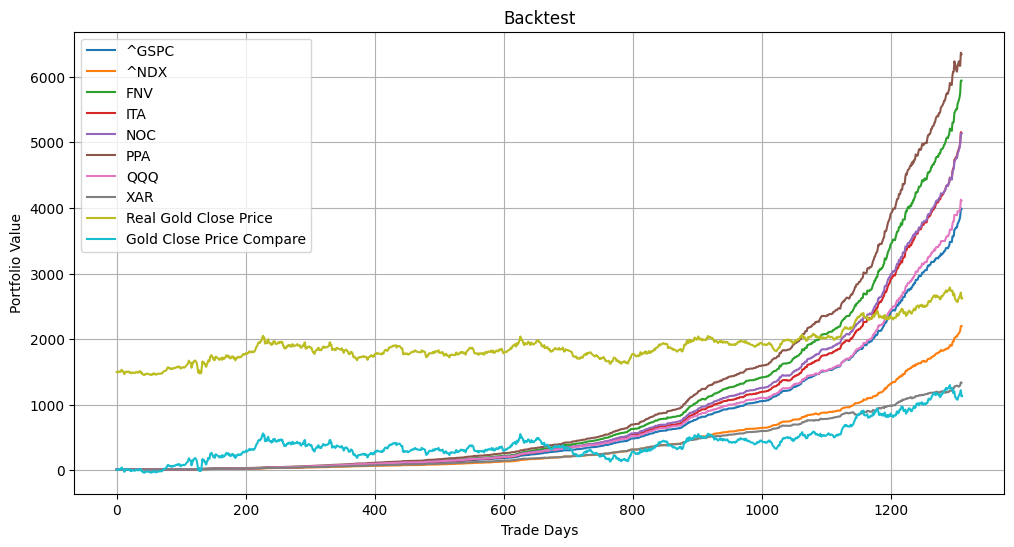

In [4]:
# Plot backtest results
plt.figure(figsize=(12, 6))
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')

more_volume = ["^GSPC", "^NDX", "FNV", "ITA", "NOC", "PPA", "QQQ", "XAR"]

for i in more_volume:
    asset = ["GC=F", i]
    data = prepar_data(asset, '2014-01-01', '2024-12-01')
    x_train, y_train, x_test, y_test, date = split_data(data.copy(), data_range=30, train_ratio=0.5)

    model = models.load_model(f"model/lstm_36n_v{i}.h5")
    scale_predict = model.predict(x_test)

    capital = 10
    capital_history = []

    for j in range(len(scale_predict) - 1):
        price_today = data["Close"]["GC=F"].loc[date[j]]
        price_next_day = data["Close"]["GC=F"].loc[date[j+1]]

        day_change = (scale_predict[j+1]-scale_predict[j])[0]
        
        if abs(day_change) > 0.002:
            capital *= 0.999
            if day_change > 0:
                profit = (price_next_day - price_today) / price_today * capital
            else:
                profit = (price_today - price_next_day) / price_today * capital
            capital += profit
            capital *= 0.999
        
        capital_history.append(capital)

    cagr.append(cal_def.cal_cagr(capital_history))
    max_dd.append(cal_def.cal_max_drawdown(capital_history))
    sd.append(cal_def.cal_sd(capital_history) * math.sqrt(250))

    plt.plot(capital_history, label=i)

gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot(gold_close_price - (gold_close_price[0]-capital_history[0]), label="Gold Close Price Compare")

plt.legend()
plt.grid(True)
plt.show()

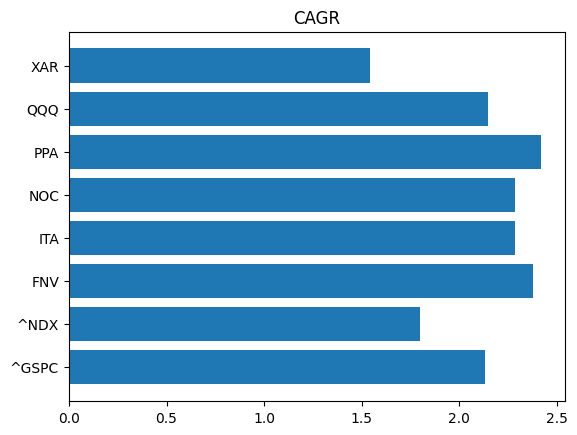

In [5]:
plt.title('CAGR')
plt.barh(more_volume, cagr)
plt.show()

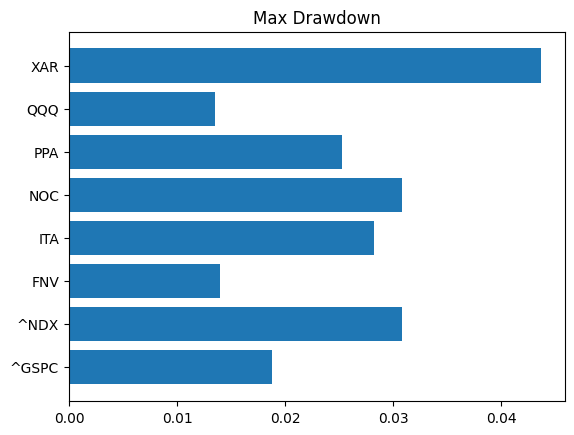

In [6]:
max_dd = [i[0] for i in max_dd]
plt.title('Max Drawdown')
plt.barh(more_volume, max_dd)
plt.show()

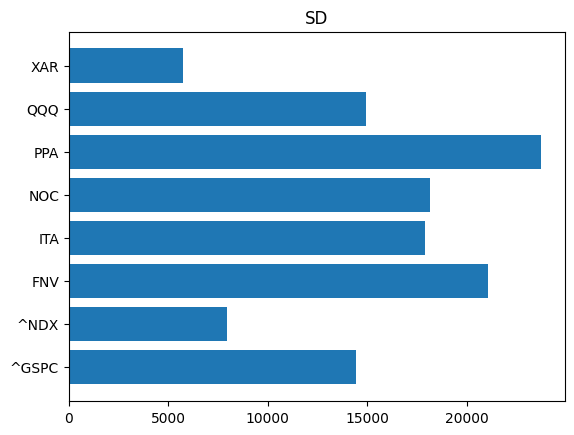

In [7]:
plt.title('SD')
plt.barh(more_volume, sd)
plt.show()